# 2-1. GCOM-W AMSR2 자료읽기, 표출하기
# 문의 (시호연: drive.hoyeon@gmail.com)

## netCDF 형식 Polar Stereographic Grid (25 km) 위경도 정보 읽기

In [1]:
import numpy as np
import netCDF4

# 본인의 directory로 변경하세요
in_dir= './Data/'
lonlatfile = in_dir+'NSIDC0771_LatLon_PS_N25km_v1.0.nc'
lonlatdata = netCDF4.Dataset(lonlatfile)
lons = np.array(lonlatdata['longitude'])
lats = np.array(lonlatdata['latitude'])

In [2]:
# Array shape, min, max 확인
print(lons.shape, np.min(lons), np.max(lons))
print(lats.shape, np.min(lats), np.max(lats))

(448, 304) -180.0 179.81397539549246
(448, 304) 31.102671752463447 89.83681599961737


## hdf5 형식 AMSR2 자료 읽기

### TB 자료 구조 확인

In [3]:
import h5py
# AMSR2 (ftp.gportal.jaxa.jp/standard/GCOM-W/GCOM-W.AMSR)
# 본인의 directory로 변경하세요
fileTB = in_dir+'GW1AM2_20230101_01D_PNMA_L3SGT06LA2220220.h5'
fTB = h5py.File(fileTB, 'r')
print(list(fTB))

['Brightness Temperature (H)', 'Brightness Temperature (V)', 'Time Information']


In [4]:
TBH_raw = fTB['Brightness Temperature (H)']
print(list(TBH_raw.attrs))

['SCALE FACTOR', 'UNIT']


In [5]:
print(TBH_raw.attrs['SCALE FACTOR'])
print(TBH_raw.attrs['UNIT'])

[0.01]
[b'K']


In [6]:
TBH_arr = np.array(TBH_raw)
print(np.min(TBH_arr), np.max(TBH_arr))

7428 65534


### TB 자료 읽어오는 함수 정의 후 읽어오기

In [7]:
# AMSR 밝기온도자료 읽어 오는 함수 정의
def readTB(filename):

    Param_H = 'Brightness Temperature (H)'
    Param_V = 'Brightness Temperature (V)'
    fTB = h5py.File(filename, 'r')

    # 수평/수직 편광 밝기온도 불러오고 scaling
    TBH = np.array(fTB[Param_H])*0.01
    TBV = np.array(fTB[Param_V])*0.01

    # missing value 처리
    TBH[np.where(TBH == 655.34)] = np.nan
    TBV[np.where(TBV == 655.34)] = np.nan

    return(TBH, TBV)

In [8]:
# 파일 명을 설정하고, 정의한 함수로 밝기온도자료 읽어 오기
# 본인의 directory로 변경하세요
fileTB = in_dir+'GW1AM2_20230101_01D_PNMA_L3SGT06LA2220220.h5'
TBH, TBV = readTB(fileTB)

# Array shape, min, max 확인
print(TBH.shape, np.nanmax(TBH), np.nanmin(TBH))
print(TBV.shape, np.nanmax(TBV), np.nanmin(TBV))

(448, 304) 370.17 74.28
(448, 304) 368.95 111.17


### SIC 자료 구조 확인

In [9]:
# 본인의 directory로 변경하세요
fSIC = h5py.File(in_dir+'GW1AM2_20230101_01D_PNMA_L3SGSICLC3300300.h5')
print(list(fSIC))

['Geophysical Data', 'Time Information']


In [10]:
SIC_raw = fSIC['Geophysical Data']
print(list(SIC_raw.attrs))

['SCALE FACTOR', 'UNIT']


In [11]:
print(SIC_raw.attrs['SCALE FACTOR'])
print(SIC_raw.attrs['UNIT'])

[0.1]
[b'%']


In [12]:
SIC_arr = np.array(SIC_raw)
print(np.min(SIC_arr), np.max(SIC_arr))

-32768 1000


### SIC 자료 읽어오는 함수 정의 후 읽어오기

In [13]:
def readSIC(filename):
    fSIC = h5py.File(filename, 'r')
    SIC = np.array(fSIC['Geophysical Data'])*0.1
    # 시간 축 제거 (x, y, t) -> (x, y)
    SIC = SIC[:,:,0]
    SIC[np.where(SIC < 0)] =np.nan
    return(SIC)

In [14]:
# 본인의 directory로 변경하세요
fileSIC = in_dir+'GW1AM2_20230101_01D_PNMA_L3SGSICLC3300300.h5'
SIC = readSIC(fileSIC)
print(SIC.shape, np.nanmax(SIC), np.nanmin(SIC))

(448, 304) 100.0 0.0


## 북극지역 자료 시각화

In [15]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as mticker

def PolarStereoMap(data, lon, lat, min_value, max_value, title, unit):
    # 그림 중심 경도, 표출할 최소/최대 위도 값 설정
    cenLon = 0
    minLat = 70
    maxLat = 90

    # Map setting
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180,180,minLat,maxLat], ccrs.PlateCarree())

    # 위경도선 그리기
    gl = ax.gridlines()
    gl.xlocator = mticker.FixedLocator([cenLon-180,
                                        cenLon-120,
                                        cenLon-60, 
                                        cenLon, 
                                        cenLon+60,
                                        cenLon+120,
                                        cenLon+180])
    ax.coastlines(resolution='50m')

    # 데이터 plot
    image = ax.scatter(lon, lat, c=data, s=10, vmin=min_value, vmax = max_value,
                        cmap = 'jet',
                        transform = ccrs.PlateCarree())

    # 제목 설정
    plt.title(title, fontsize=30, pad=20)

    # Color bar 설정
    cbar = plt.colorbar(image, orientation = 'vertical', extend='both')
    cbar.set_label(unit, fontsize=20)
    cbar.ax.tick_params(labelsize=30)

    # 위경도 레이블 설정
    latlabels=[]
    lons_latlabel = [0] * 3
    lats_latlabel = np.arange(3, dtype=np.int32) * 10 + minLat

    for templat in lats_latlabel:
        latlabels.append(str(templat) + '°N')

    for label, xpt, ypt in zip(latlabels, lons_latlabel, lats_latlabel):
        plt.text(xpt, ypt, label, ha = 'center', fontsize=15, transform = ccrs.PlateCarree())

    lonlabels = []
    lons_lonlabel = np.array([60,120,180,-120,-60])
    lats_lonlabel = [minLat]*5

    for templon in lons_lonlabel:
        if templon > 0 and templon <180:
            lonlabels.append(str(templon) + '°E')
        if templon == 180:
            lonlabels.append(str(templon))
        if templon < 0:
            lonlabels.append(str(-templon) + '°W')

    for label, xpt, ypt in zip(lonlabels, lons_lonlabel, lats_lonlabel):
        plt.text(xpt, ypt, label, ha = 'center', fontsize=15, transform = ccrs.PlateCarree())

    #자료 표출
    plt.tight_layout()
    plt.show()

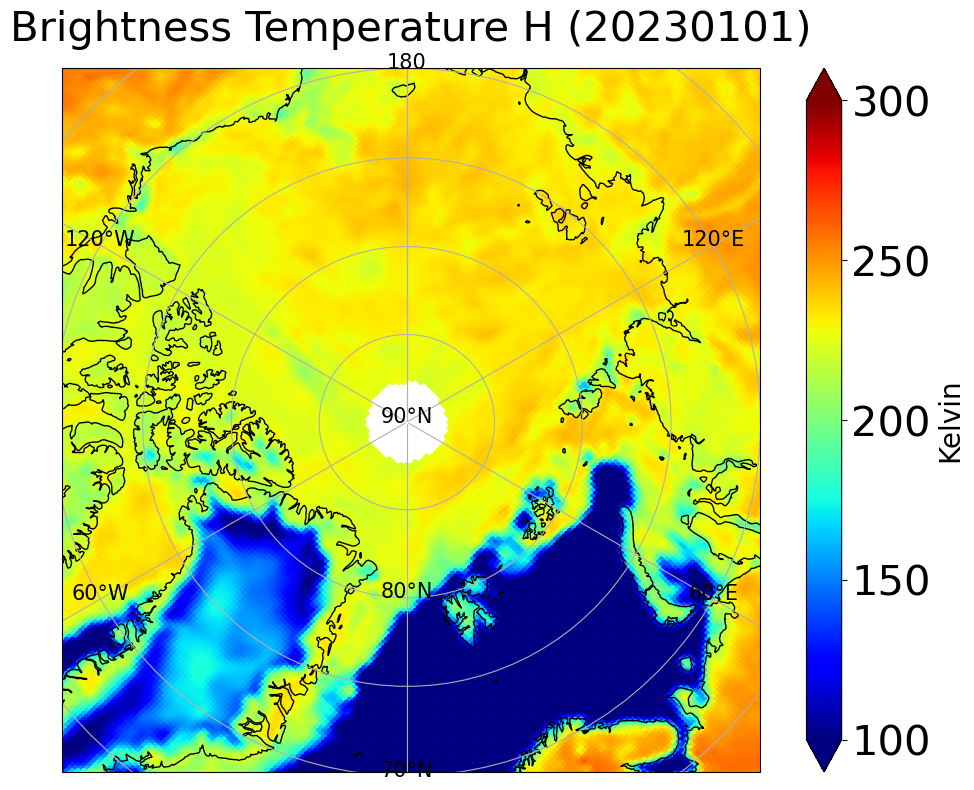

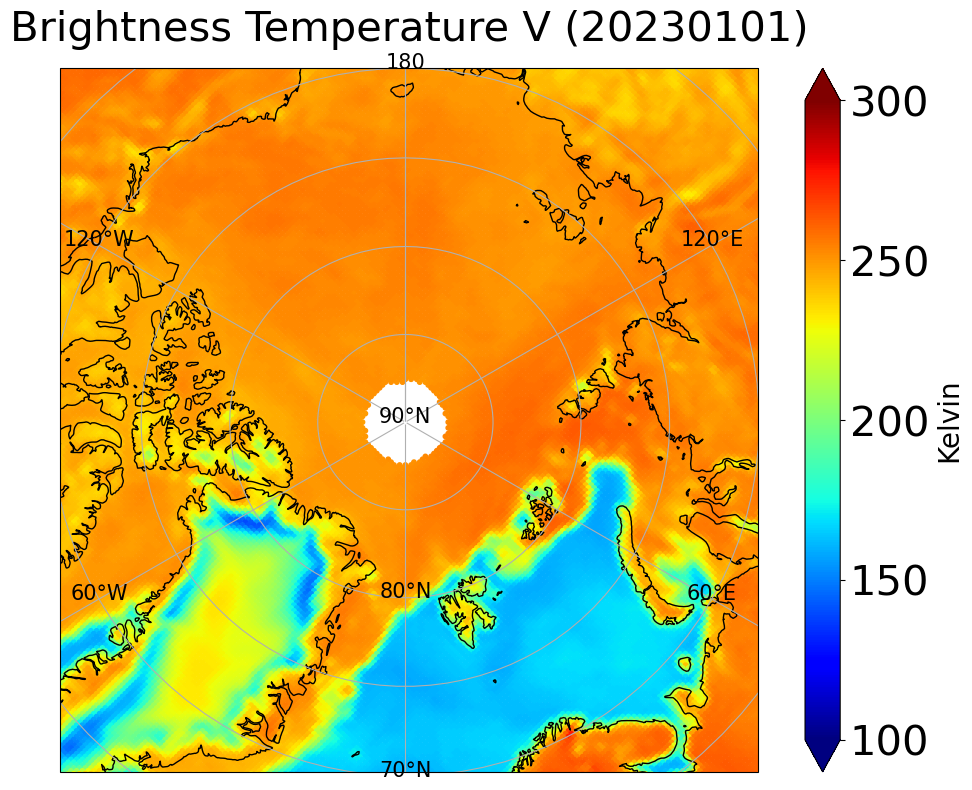

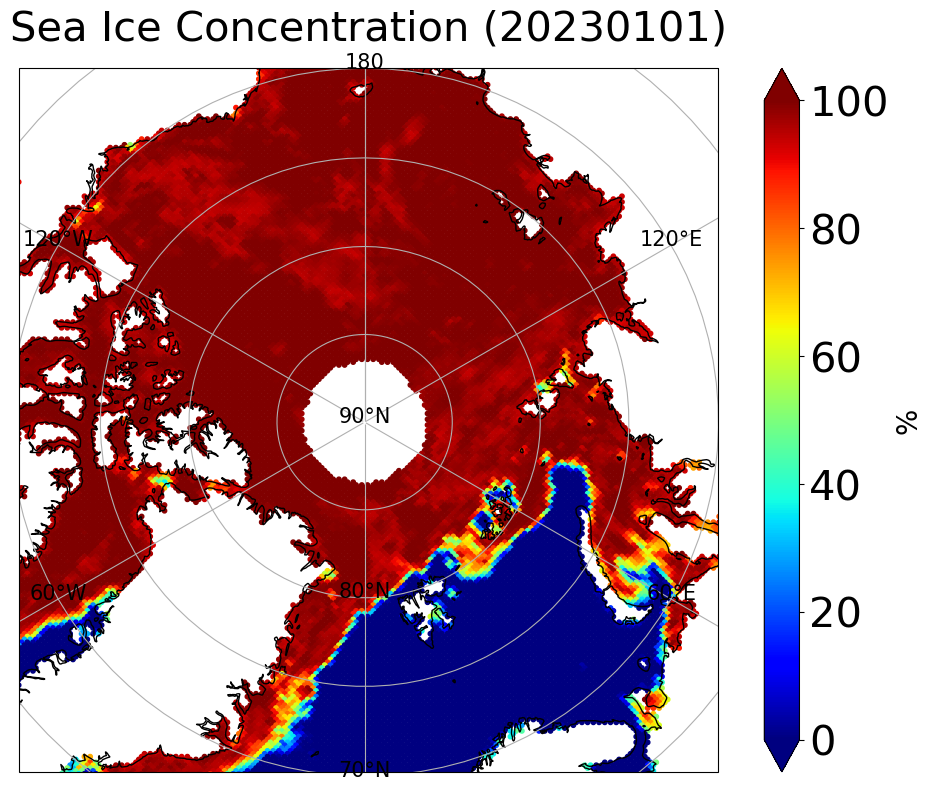

In [16]:
# TBH, TBV, SIC 자료 plot
PolarStereoMap(TBH, lons, lats, 100, 300, 'Brightness Temperature H (20230101)', 'Kelvin')
PolarStereoMap(TBV, lons, lats, 100, 300, 'Brightness Temperature V (20230101)', 'Kelvin')
PolarStereoMap(SIC, lons, lats, 0, 100, 'Sea Ice Concentration (20230101)', '%')

## 해빙 면적 시계열 그래프

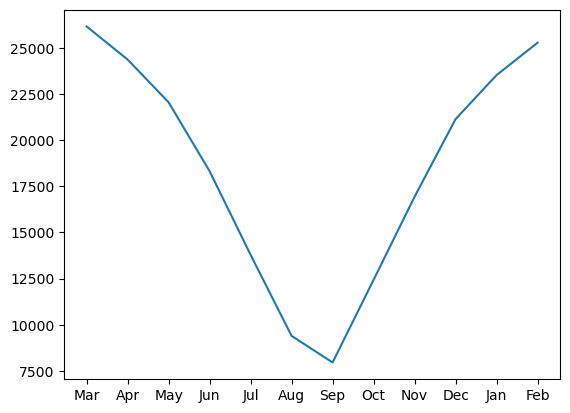

In [17]:
import glob

# 본인 directory에 맞게 변경하세요 (01M은 월평균 자료를 지칭)
file_list_SIC = glob.glob(in_dir+'*_01M_*')
file_list_SIC.sort()

SIE_series = []
for i in range(len(file_list_SIC)):
    SIC = readSIC(file_list_SIC[i])
    spotSICgt15 = np.where(SIC >= 15)
    SIE = len(spotSICgt15[0])
    SIE_series.append(SIE)

plt.plot(['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb'], SIE_series)

plt.show()

# 2-2. 위성관측 밝기온도로부터 해빙방출률 산출하기

## 아래식을 만족하는 RH 값 구하기

\begin{gather*}
\frac{TB_H}{TB_V} = \frac{1 - R_H}{1 - f(R_H)}
\end{gather*}

In [18]:
def CombFresEq(Rh, theta): # Combined Fresnel equation f(Rh)

    cos = np.cos(2. * np.deg2rad(theta))

    Rv = (Rh**2.) * ((1.+cos/np.sqrt(Rh)) / (1. + cos * np.sqrt(Rh)))**2.

    return(Rv)

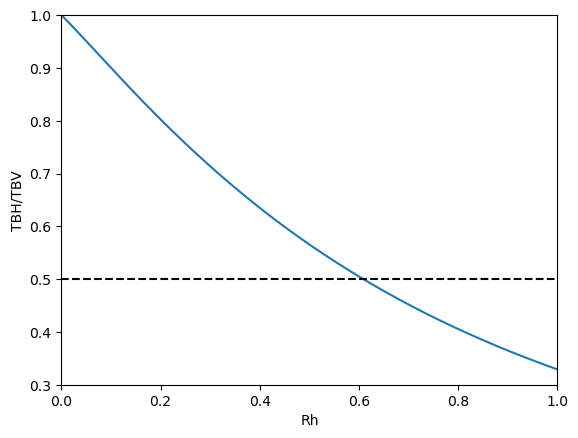

In [19]:
Rh = np.arange(0.0001, 1, 0.0001)
ratio = (1.-Rh)/(1.-CombFresEq(Rh, 55.))
ratio_sample = 0.5

plt.plot(Rh, ratio)
#plt.plot([0,1], [ratio_sample]*2, 'k--')
plt.axhline(y = ratio_sample, color = 'k', ls = '--')
plt.xlim(0,1)
plt.ylim(0.3,1)
plt.xlabel('Rh')
plt.ylabel('TBH/TBV')
plt.show()

## Numerical solver 정의

In [20]:
def solver(c, theta):
    Rh_now = 0.5
    Rh_0 = 0.0001
    Rh_1 = 0.9999
    while True:
        c_now = (1.-Rh_now)/(1.-CombFresEq(Rh_now, theta))
        if abs(c_now-c)<0.0001:
            return(Rh_now)
            break
        else :
            if c_now-c > 0.:
                Rh_0 = Rh_now
                Rh_1 = Rh_1
                Rh_now = (Rh_now+Rh_1)/2.
            else :
                Rh_0 = Rh_0
                Rh_1 = Rh_now
                Rh_now = (Rh_now+Rh_0)/2.
    return(Rh_now)

## Solver 작동 확인

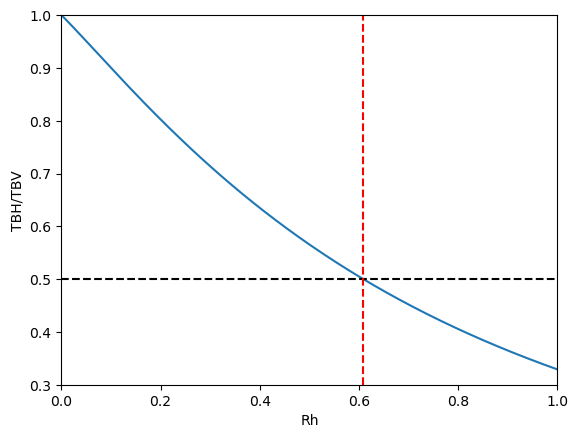

In [21]:
Rh_solution = solver(ratio_sample, 55)
plt.plot(Rh, ratio)
#plt.plot([0,1], [ratio_sample]*2, 'k--')
#plt.plot([Rh_solution]*2, [0,1], 'r--')
plt.axhline(y = ratio_sample, color = 'k', ls = '--')
plt.axvline(x = Rh_solution, color = 'r', ls ='--')
plt.xlim(0,1)
plt.ylim(0.3,1)
plt.xlabel('Rh')
plt.ylabel('TBH/TBV')
plt.show()

## 북극 전 영역에 적용

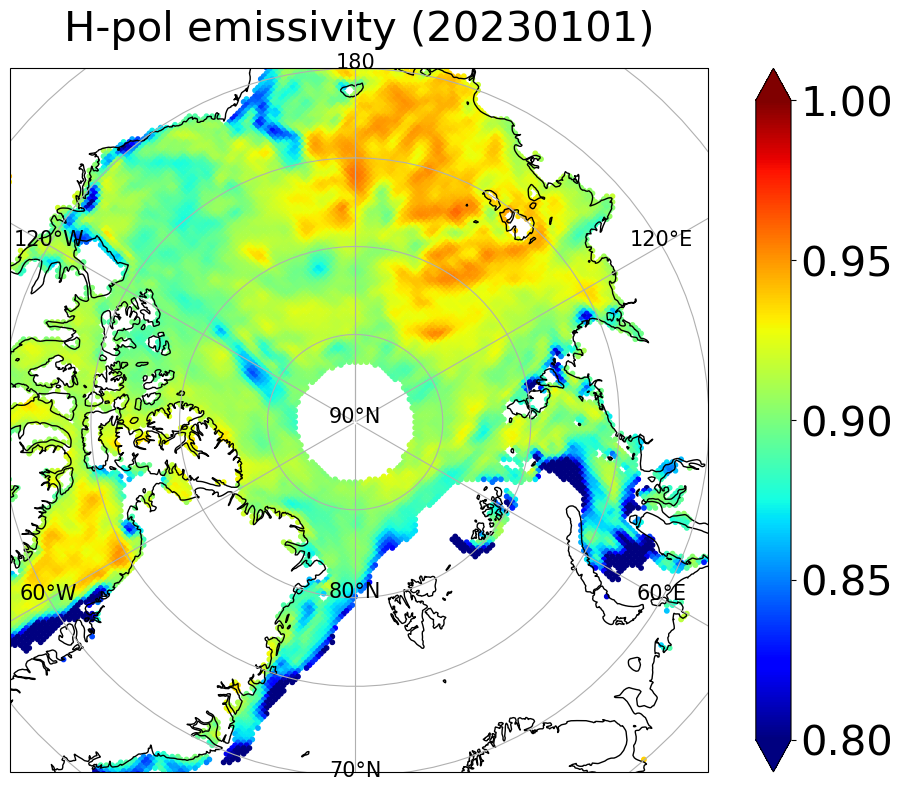

In [22]:
ratios = TBH/TBV

RH = np.zeros((448,304)) * np.nan
for i in range(448):
    for j in range(304):
        ratio = ratios[i,j]
        if (np.isfinite(ratio)) & (SIC[i,j] >= 95):
            RH[i,j] = solver(ratio, 55)

RV = CombFresEq(RH, 55.)
EV = 1. - RV
EH = 1. - RH

Ts = TBH/EH

PolarStereoMap(EH, lons, lats, 0.8, 1, 'H-pol emissivity (20230101)', '')

# 2-3. ICESat-2 위성 트랙자료를 격자자료로 변환하기

## ICESat-2 자료 읽어오기

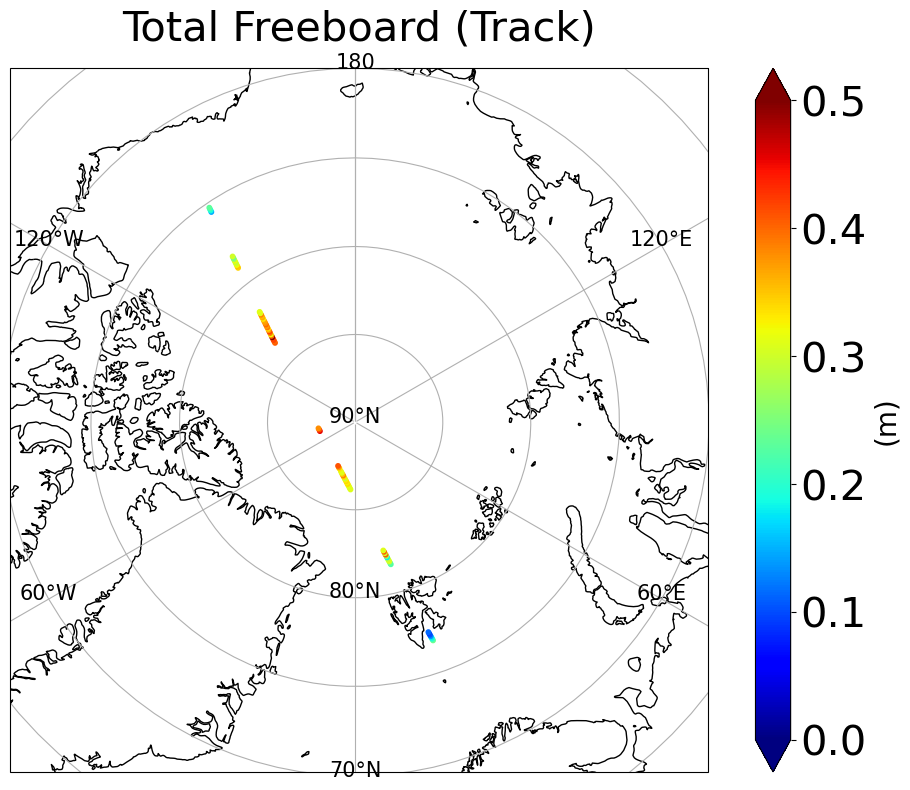

In [23]:
def readIS2(fileIS2):
    f = h5py.File(fileIS2, 'r')
    gt1l = f['gt1l/freeboard_beam_segment']
    htf1l = np.array(gt1l['beam_fb_height'])
    htf1l[np.where(htf1l > 100)] = np.nan # 비정상수치 제거
    lon1l = np.array(gt1l['longitude'])
    lat1l = np.array(gt1l['latitude'])
    return(lon1l, lat1l, htf1l)

# 본인의 directory로 변경하세요
filename_IS2 = in_dir+'ATL10-01_20220101051533_01521401_005_01.h5'
lons_sat, lats_sat, htfs_sat = readIS2(filename_IS2)

PolarStereoMap(htfs_sat, lons_sat, lats_sat, 0, 0.5,
'Total Freeboard (Track)', '(m)')

## 거리 계산, 자료 할당 및 평균계산

In [24]:
# 25 km psn gird 불러오기 (본인의 directory로 변경하세요)
lonlatfile = in_dir+'NSIDC0771_LatLon_PS_N25km_v1.0.nc'
lonlatdata = netCDF4.Dataset(lonlatfile)
lons_grid = np.array(lonlatdata['longitude'])
lats_grid = np.array(lonlatdata['latitude'])

In [25]:
# 모든 각도의 단위를 도에서 radian으로 변환
lons_sat_rad = np.radians(lons_sat)
lats_sat_rad = np.radians(lats_sat)
lons_grid_rad = np.radians(lons_grid)
lats_grid_rad = np.radians(lats_grid)

In [26]:
Re = 6371.228 # 지구의 반지름

In [27]:
total = np.zeros((448,304))  # 자료 할당을 위한 array
count = np.zeros((448,304)) # 할당된 자료 수 count

for i in range(len(htfs_sat)):
    htf0 = htfs_sat[i]
    if np.isfinite(htf0) == 0:
        continue

    lon0_rad = lons_sat_rad[i]
    lat0_rad = lats_sat_rad[i]

    havs_lat = np.sin((lats_grid_rad - lat0_rad)/2.)**2.
    havs_lon = np.sin((lons_grid_rad - lon0_rad)/2.)**2.

    # Haversine 공식으로 거리 계산
    dist_array = 2.*Re*np.arcsin(np.sqrt(havs_lat + np.cos(lats_grid_rad)*np.cos(lat0_rad) * havs_lon))

    spot = np.where(dist_array == np.nanmin(dist_array))
    x0 = spot[0][0]
    y0 = spot[1][0]
    dist0 = dist_array[spot]

    if dist0 > np.sqrt(12.5*12.5+12.5*12.5):
        continue
    total[spot] = total[spot] + htf0
    count[spot] = count[spot] + 1.

htfs_grid = total/count

C:\Users\Hoyeon\AppData\Local\Temp\ipykernel_14896\2142941564.py:28: RuntimeWarning: invalid value encountered in divide
  htfs_grid = total/count


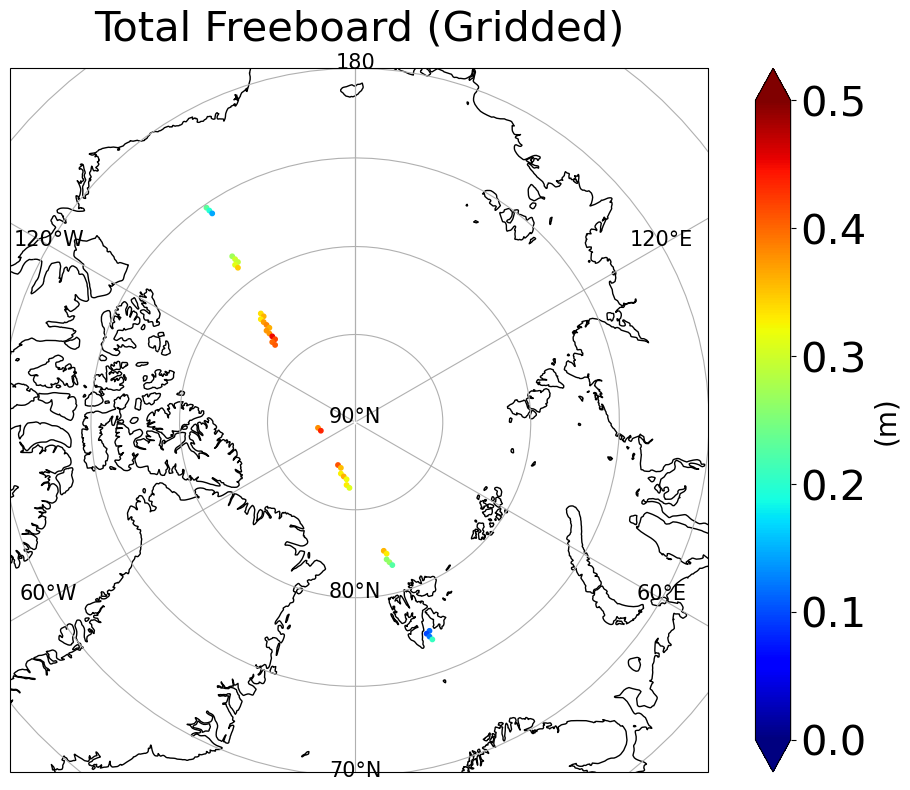

In [28]:
PolarStereoMap(htfs_grid, lons_grid, lats_grid, 0, 0.5,
 'Total Freeboard (Gridded)', '(m)')